In [69]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [70]:
# Hyper Parameters
BATCH_SIZE = 64
LR_G = 0.0001       # 生成器的学习率
LR_D = 0.0001       # 判别器的学习率
N_IDEAS = 5         # 生成器作品的调试次数
ART_COMPONENTS = 15 # g在画布上的点数
PAINT_POINTS = np.vstack([np.linspace(-1, 1, ART_COMPONENTS) for _ in range(BATCH_SIZE)])

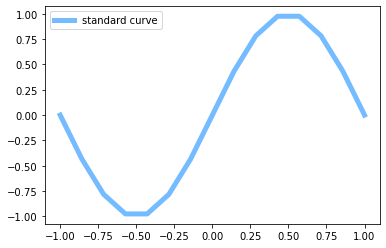

In [71]:
# 显示我们的模板图像
plt.plot(PAINT_POINTS[0], np.sin(PAINT_POINTS[0] * np.pi), c='#74BCFF', lw=5, label='standard curve')
plt.legend(loc='best')
plt.show()

In [72]:
def artist_works():     # real target
    r = 0.02 * np.random.randn(1, ART_COMPONENTS)
    paintings = np.sin(PAINT_POINTS * np.pi ) + r
    paintings = torch.from_numpy(paintings).float()
    return paintings

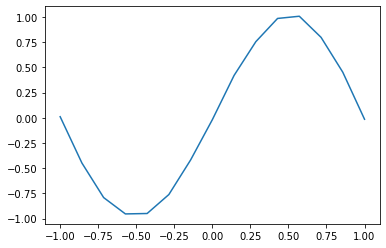

In [73]:
r = 0.02 * np.random.randn(1, ART_COMPONENTS)
paintings = np.sin(PAINT_POINTS * np.pi) + r
plt.plot(PAINT_POINTS[0],paintings[0])
plt.show()

In [74]:
G = nn.Sequential(      # Generator
    nn.Linear(N_IDEAS, 128),    # 数据来自randn
    nn.ReLU(),
    nn.Linear(128, ART_COMPONENTS),      # 用这些随机点进行画画
)

D = nn.Sequential(      # Discriminator
    nn.Linear(N_IDEAS, 128),        # 接受来自generator的点
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid(),      #   告诉艺术作品是由艺术家创作的概率
)

In [75]:
opt_D = torch.optim.Adam(D.parameters(), lr=LR_D)
opt_G = torch.optim.Adam(G.parameters(), lr=LR_G)

plt.ion()    # something about continuous plotting

D_loss_history = []
G_loss_history = []
for step in range(10000):
    artist_paintings = artist_works()          # real painting from artist
    G_ideas = torch.randn(BATCH_SIZE, N_IDEAS) # random ideas
    G_paintings = G(G_ideas)                   # fake painting from G (random ideas)

    prob_artist0 = D(artist_paintings)         # D try to increase this prob
    prob_artist1 = D(G_paintings)              # D try to reduce this prob

    D_loss = - torch.mean(torch.log(prob_artist0) + torch.log(1. - prob_artist1))
    G_loss = torch.mean(torch.log(1. - prob_artist1))

    D_loss_history.append(D_loss)
    G_loss_history.append(G_loss)

    opt_D.zero_grad()
    D_loss.backward(retain_graph=True)    # reusing computational graph
    opt_D.step()

    opt_G.zero_grad()
    G_loss.backward()
    opt_G.step()

    if step % 50 == 0:  # plotting
        plt.cla()
        plt.plot(PAINT_POINTS[0], G_paintings.data.numpy()[0], c='#4AD631', lw=3, label='Generated painting',)
        plt.plot(PAINT_POINTS[0], np.sin(PAINT_POINTS[0] * np.pi), c='#74BCFF', lw=3, label='standard curve')
        plt.text(-1, 0.75, 'D accuracy=%.2f (0.5 for D to converge)' % prob_artist0.data.numpy().mean(), fontdict={'size': 8})
        plt.text(-1, 0.5, 'D score= %.2f (-1.38 for G to converge)' % -D_loss.data.numpy(), fontdict={'size': 8})
        plt.ylim((-1, 1));plt.legend(loc='lower right', fontsize=10);plt.draw();plt.pause(0.01)

plt.ioff()
plt.show()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x15 and 5x128)